### Imports

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import math
from sklearn.metrics import mean_squared_log_error

## SIRD model in Python 

In [2]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((gamma+rho)*I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [3]:
# Function used to get the values of the SIRD model, if plotting is not necessary
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T


    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [4]:
# Function used to plot SIRD model
# sird_true, if true, return all components of SIRD model, if not, return D only
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true,label,init_val):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T



    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, (D+init_val), alpha=1, lw=2, label=label)
        # SD SIR equation
        ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
        Sm, Im, Rm, Dm = ret.T 

        # SD SIR equation
        ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
        Sp, Ip, Rp, Dp = ret.T 

        ax.fill_between(t+offset, (Dm+init_val), (Dp+init_val), alpha=0.2, edgecolor='black',  label="Standard Deviation")


    # Creating Labels for graph
    ax.set_xlabel('Time after start of observation (days)')
    ax.set_ylabel('Cumulative Deaths due to COVID-19')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D
    

In [5]:
# Function used to plot real data
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
    else:
        deaths = data["cumDeath"]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Cumulative Deaths due to COVID-19", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Cumulative Deaths due to COVID-19", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Cumulative Deaths due to COVID-19", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Cumulative Deaths due to COVID-19", linestyle = 'None')
    legend = graph.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    legend.get_frame().set_alpha(0.5)
    return graph
    

In [6]:
# Function to add time and return in the format %Y-%m-%d
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')

# Function to return time total between two dates, in int form
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

### Example SIRD Model

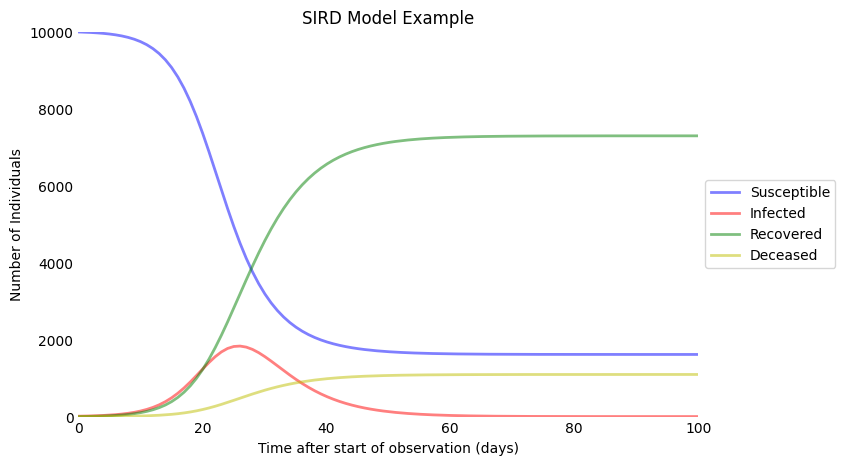

In [7]:
fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
plotSIRD(ax1,300,10000,10,0.5,0.2,0.03,[0,10000],[0,100],None,0,True,"none",0)
ax1.set_ylabel("Number of Individuals")
ax1.set_title("SIRD Model Example")
ax1.legend( loc='center left', bbox_to_anchor=(1, 0.5))

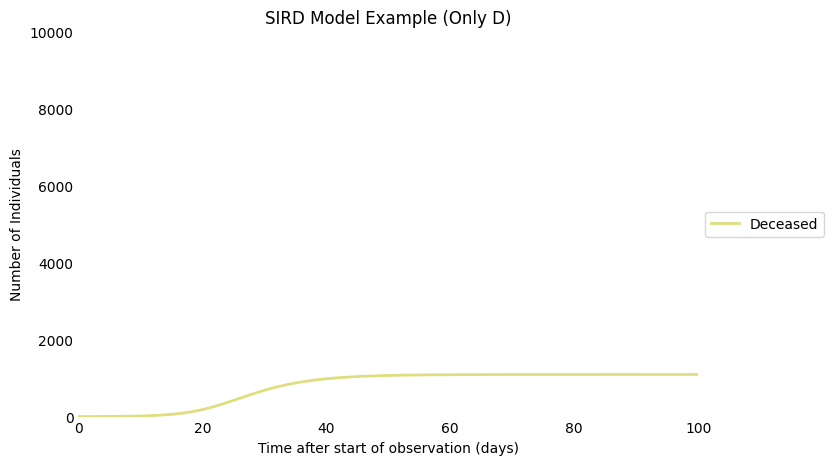

In [52]:
fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
plotSIRD(ax1,300,10000,10,0.5,0.2,0.03,[0,10000],[0,100],None,0,True,"none",0)
ax1.set_ylabel("Number of Individuals")
ax1.set_title("SIRD Model Example (Only D)")
ax1.legend( loc='center left', bbox_to_anchor=(1, 0.5))

## Prepare all Datasets 

In [13]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            }
}


## First Lockdown

### Goodness of Fit

In [12]:

country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_observed_data = dataset[country]['data']
    df_parameters = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_observed_data[df_observed_data['date'] == startDate].index

    # Read CSV of CumDeaths
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    
    # Get Quarantine Date
    firstDate = realData.loc[0]['date']

    obs_deaths = df_observed_data["cumDeath"].tolist()

    # Get value before start of observed deaths
    init_death = obs_deaths[startDate[0]-11]
    obs_deaths = obs_deaths[startDate[0]-10:startDate[0]+5]

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(60,pop, df_parameters.loc[3][1],df_parameters.loc[0][1],df_parameters.loc[1][1],df_parameters.loc[2][1], [df_parameters.loc[0][2], df_parameters.loc[1][2], df_parameters.loc[2][2]] )
    
    # Get D compartment
    pred_deaths = sird[3]

    # Select the range that were used to obtain the values
    pred_deaths = pred_deaths[0:15] + init_death

    # Calculate R2 and RMSE
    k = 5 # number of parameters (beta, gamma, rho, i0, s0)
    r2 = r2_score(obs_deaths, pred_deaths)
    r2 = 1 - (1-r2)*(len(obs_deaths)-1)/(len(obs_deaths)-k-1)
    rmse =  np.sqrt(mean_squared_log_error(obs_deaths, pred_deaths))

    n = len(obs_deaths)
    
    # AIC Value (NOT USED)
    rss = np.sum((obs_deaths-pred_deaths)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','Adjusted R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,Adjusted R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.932070,0.292729,56.108685
1,France,0.916106,0.633470,117.761138
2,Germany,0.966703,0.240165,95.179430
3,Italy,0.986180,0.155138,117.649726
4,Spain,0.958084,0.551105,130.455679
5,UK,0.973291,0.108080,147.277824


In [14]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_observed_data = dataset[country]['data']
    df_parameters = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_observed_data[df_observed_data['date'] == startDate].index

    # Read CSV of CumDeaths
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    
    # Get Quarantine Date
    firstDate = realData.loc[0]['date']

    obs_deaths = df_observed_data["cumDeath"].tolist()

    # Get value before start of observed deaths
    init_death = obs_deaths[startDate[0]+4]
    obs_deaths = obs_deaths[startDate[0]+5:startDate[0]+20]

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(60,pop, df_parameters.loc[3][1],df_parameters.loc[0][1],df_parameters.loc[1][1],df_parameters.loc[2][1], [df_parameters.loc[0][2], df_parameters.loc[1][2], df_parameters.loc[2][2]] )
    
    # Get D compartment
    pred_deaths = sird[3]

    # Select the range that were used to obtain the values
    pred_deaths = pred_deaths[0:15] + init_death

    # Calculate R2 and RMSE
    k = 5 # number of parameters (beta, gamma, rho, i0, s0)
    r2 = r2_score(obs_deaths, pred_deaths)
    r2 = 1 - (1-r2)*(len(obs_deaths)-1)/(len(obs_deaths)-k-1)
    rmse =  np.sqrt(mean_squared_log_error(obs_deaths, pred_deaths))

    n = len(obs_deaths)
    
    # AIC Value (NOT USED)
    rss = np.sum((obs_deaths-pred_deaths)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','Adjusted R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,Adjusted R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.986215,0.096046,121.770524
1,France,0.929159,0.131161,196.913641
2,Germany,0.994727,0.062565,136.396443
3,Italy,0.962391,0.065272,191.000692
4,Spain,0.996571,0.072300,162.468152
5,UK,0.997183,0.055059,170.241380


### First Quarantine Analysis

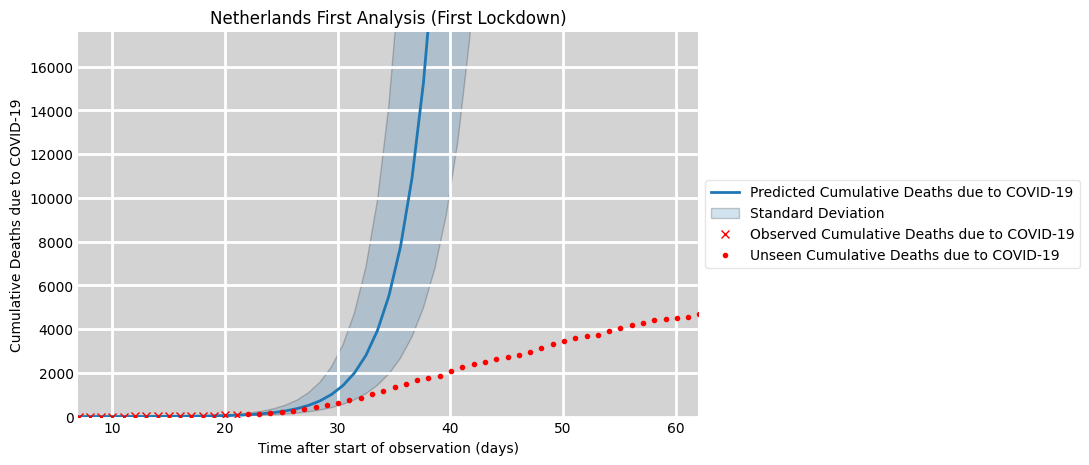

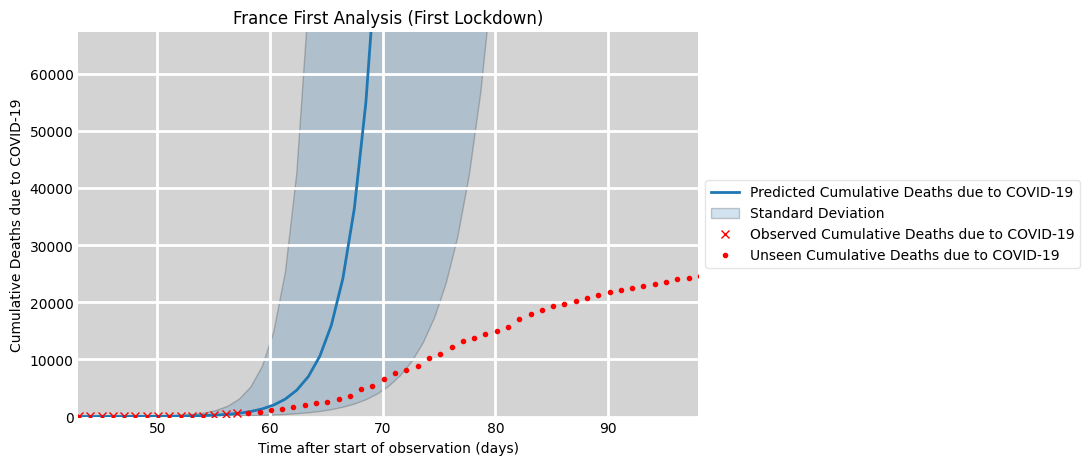

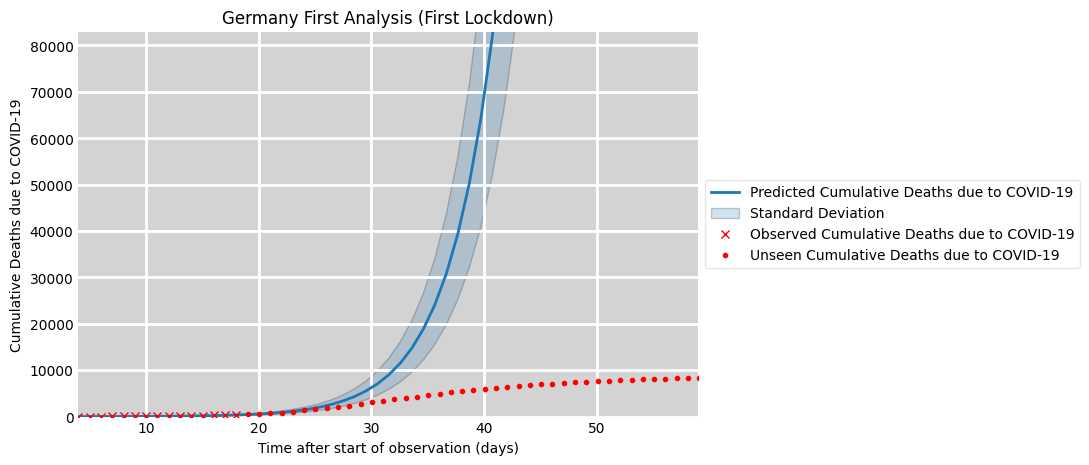

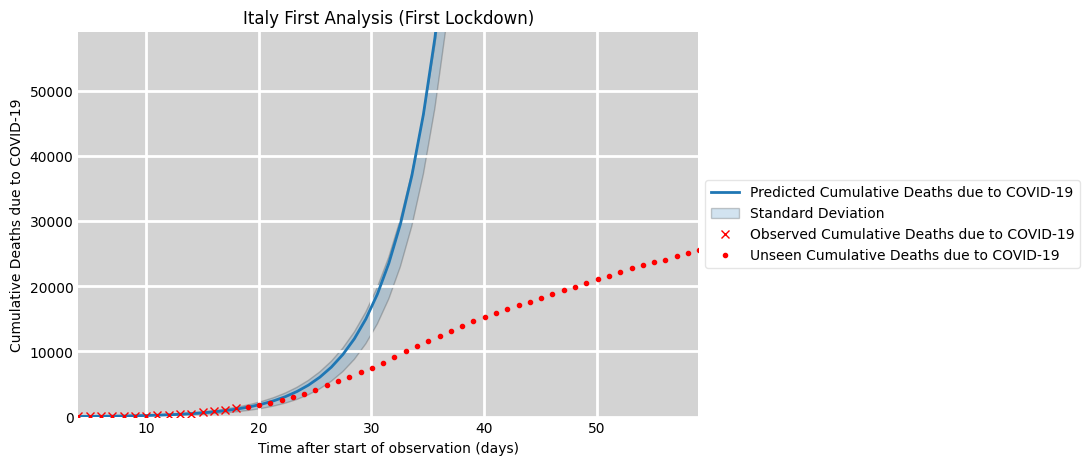

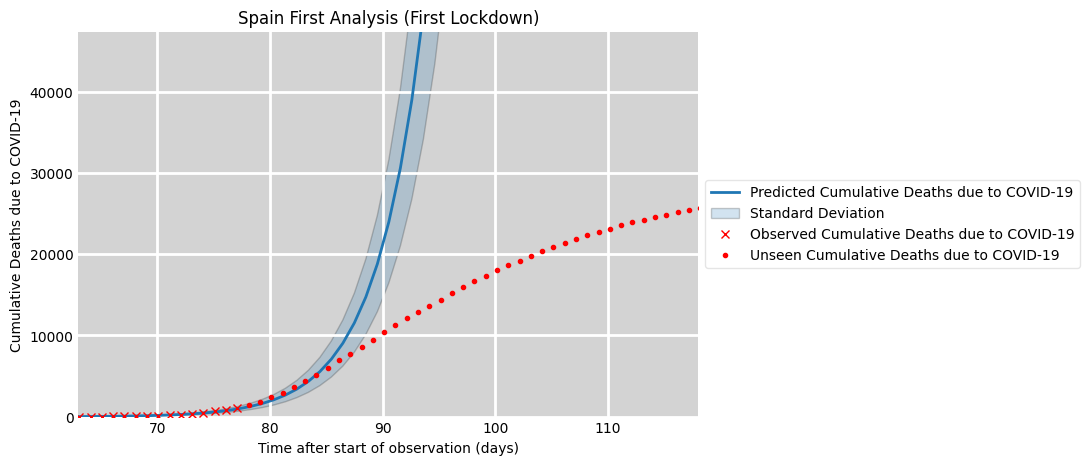

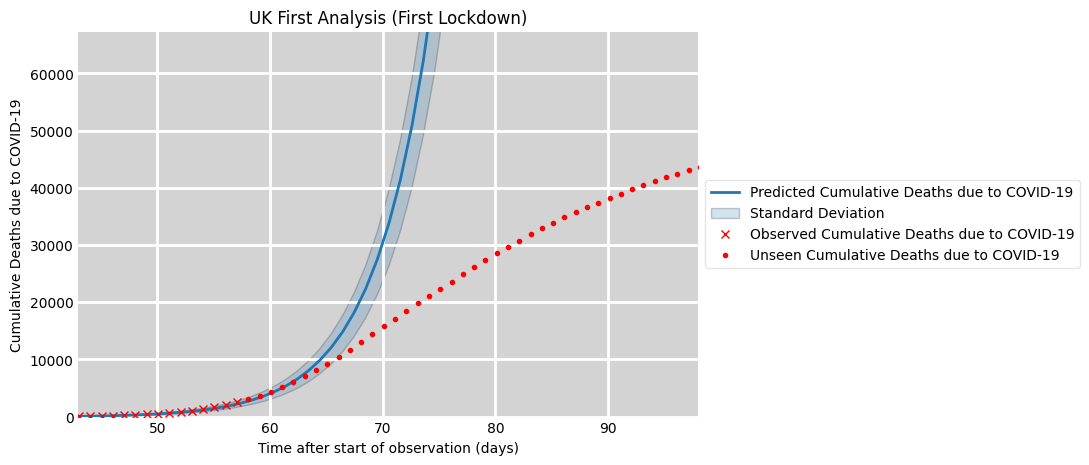

In [15]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,5))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")

    death = realData["cumDeath"].tolist()
    
    graph = plotSIRD(ax1,50, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+40], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False,"Predicted Cumulative Deaths due to COVID-19",death[obvData_start-1])
    ax1.set_title(country + " First Analysis (First Lockdown)")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,0)

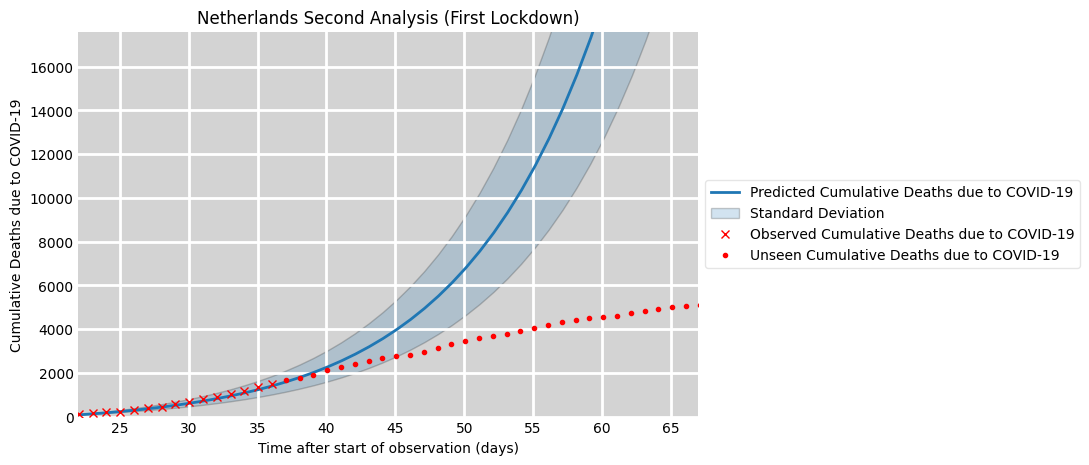

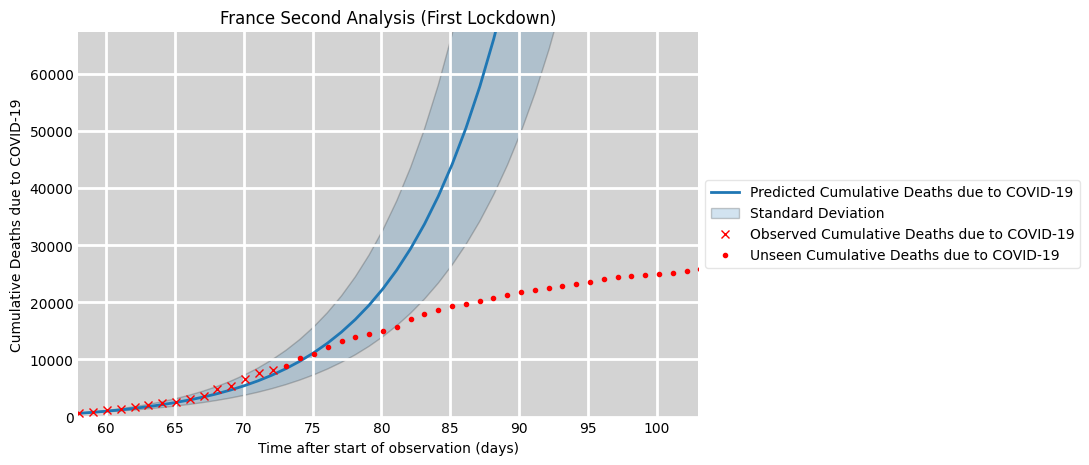

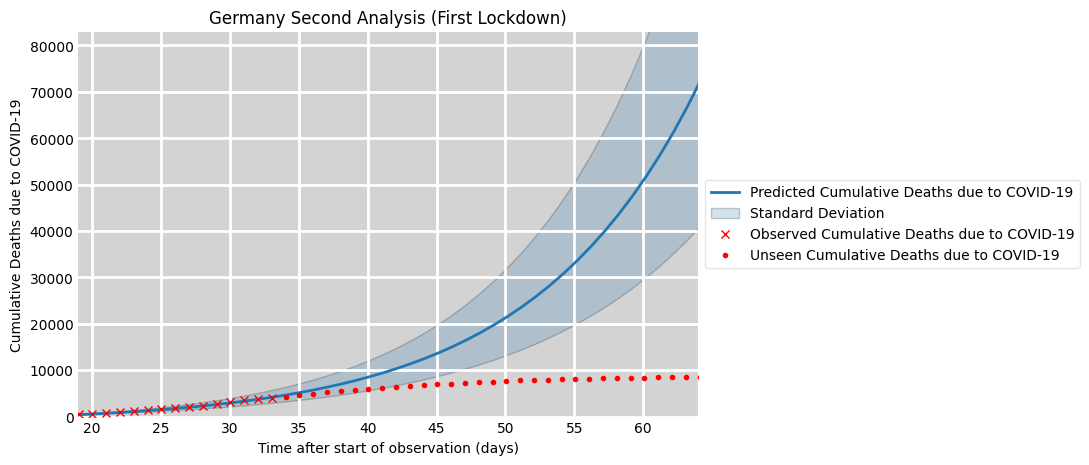

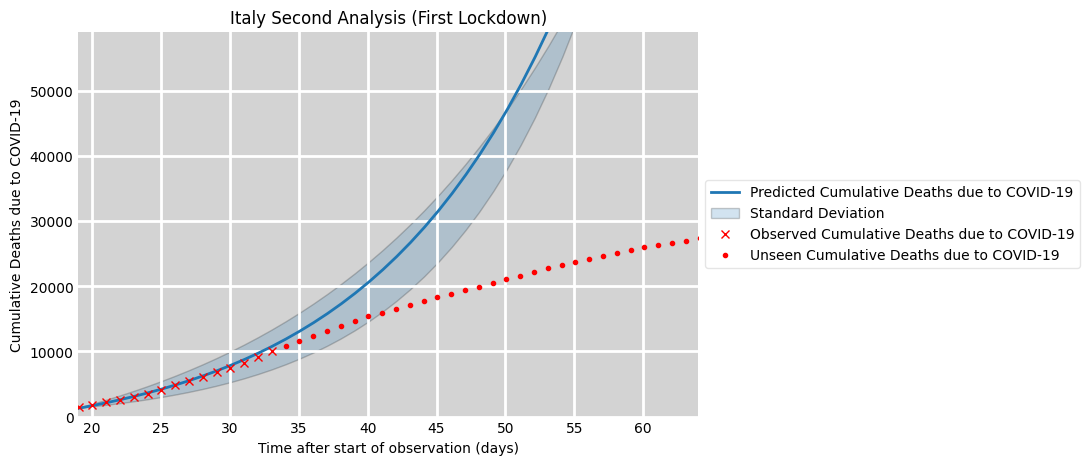

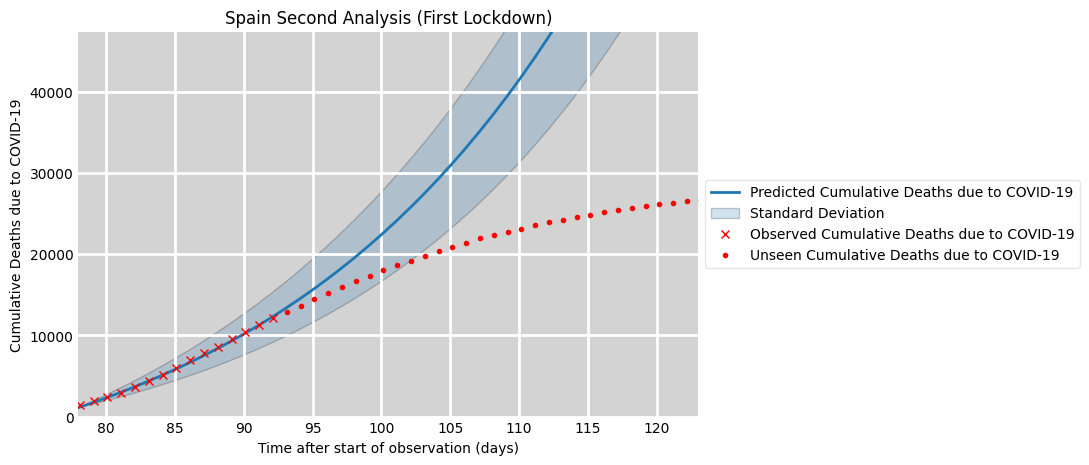

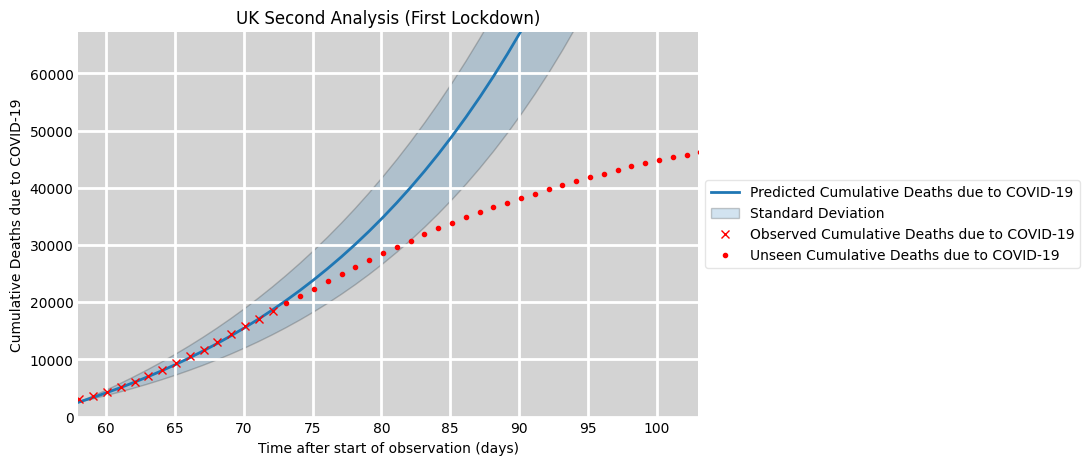

In [16]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)+5
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")

    death = realData["cumDeath"].tolist()

    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+30], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+5, False,"Predicted Cumulative Deaths due to COVID-19",death[obvData_start-1])
    sird_deaths[country] = {
        'deaths':graph,
        'date': obvData_end+30
    }
    ax1.set_title(country + " Second Analysis (First Lockdown)")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,14,True)

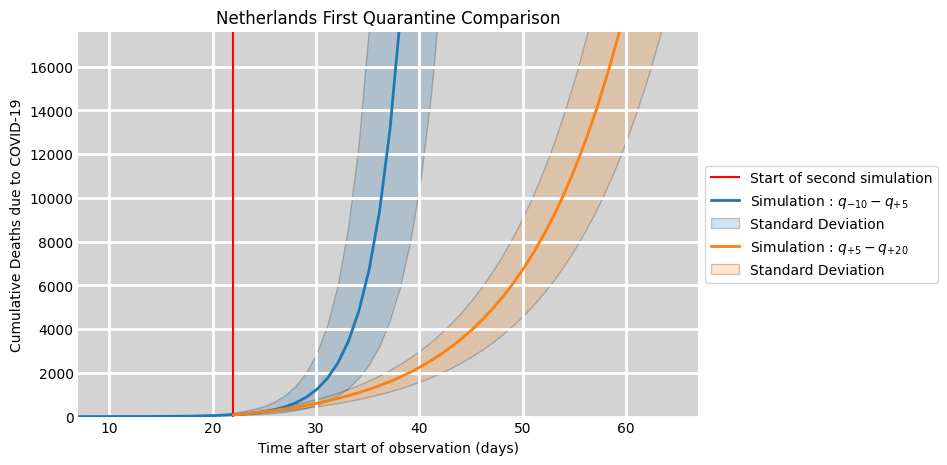

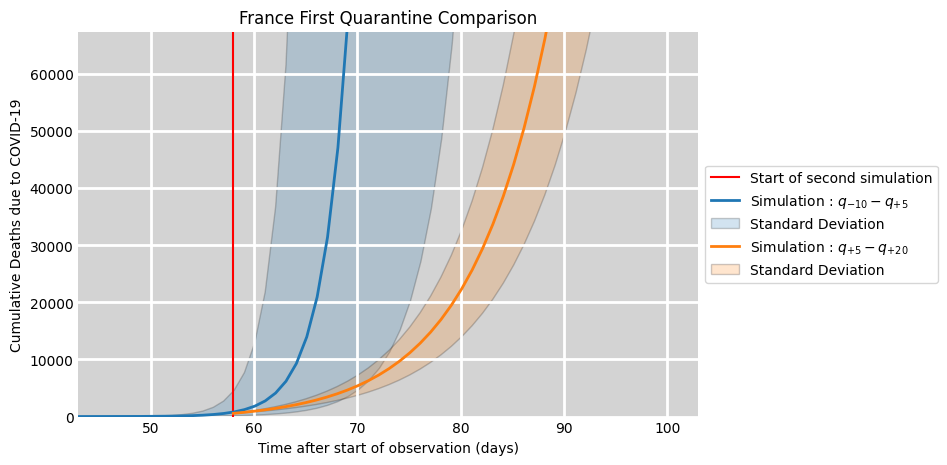

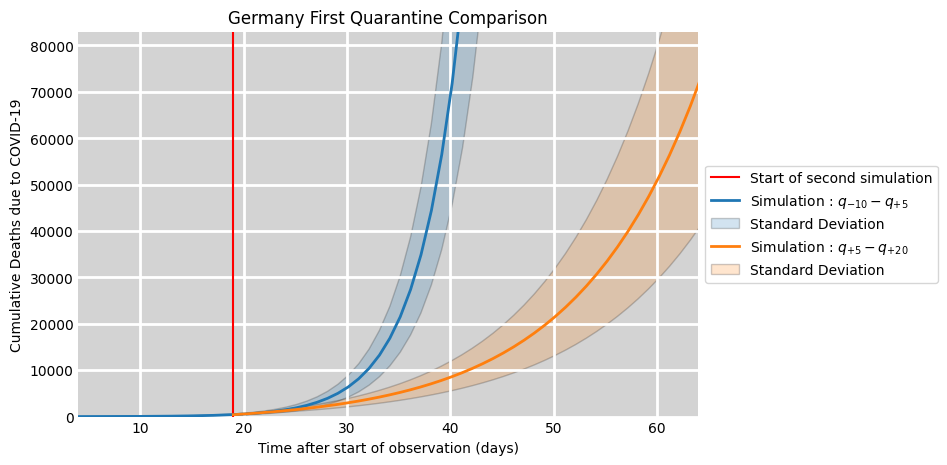

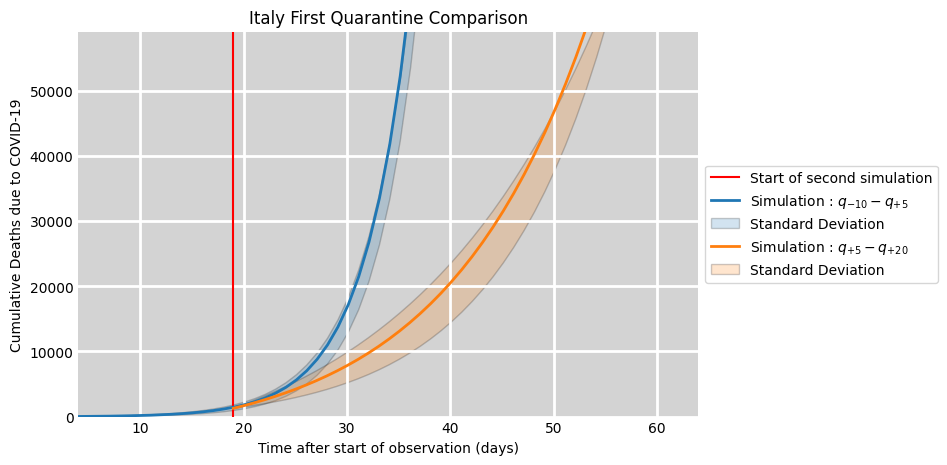

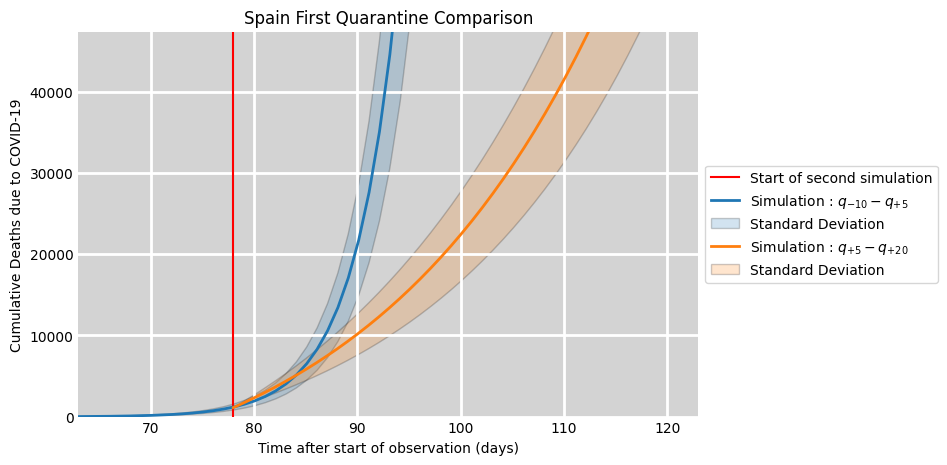

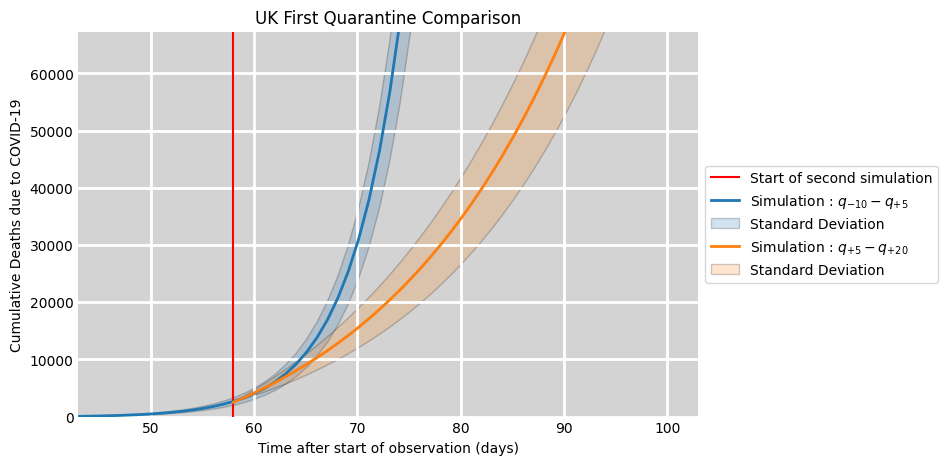

In [21]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    offset=0

    death = realData["cumDeath"].tolist()

    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,0))
    plt.axvline(x=obvData_start+15, c="red", label="Start of second simulation")
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False,"Simulation : $q_{-10}-q_{+5}$",death[obvData_start-1])
    sird_deaths[country+str("_before")] = graph
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+5, False, "Simulation : $q_{+5}-q_{+20}$",death[obvData_start+14])
    sird_deaths[country+str("_after")] = graph
    ax1.set_title(country + " First Quarantine Comparison")
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('results/first_q/'+country+'.png')

### Italy's Extra Analysis

In [17]:
def fullAnalaysis_SIRD(country,time):
    fig, ax = plt.subplots(1,1, figsize=(8,5))    
    ax.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    # before
    obvData_start = timeTot(firstDate,startDate)-10
    death = realData["cumDeath"].tolist()
    obvData_end = timeTot(firstDate,addTime(startDate,35))

    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax,time, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [0,60], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, "q-10 to q+5",death[obvData_start-1])

    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax,time, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [0,60], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+5, False, "q+5 to q+20",death[obvData_start+14])

    df = pd.read_csv('mcmc_data/'+country+"/fLock_further_analysis.csv")
    graph = plotSIRD(ax,time, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [0,60], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+20, False, "q+20 to q+35",death[obvData_start+29])
    ax.set_title("Italy First Lockdown Full Analysis")
    final_graph =plotRealData(ax, realData, obvData_start, obvData_end, graph,14,True)

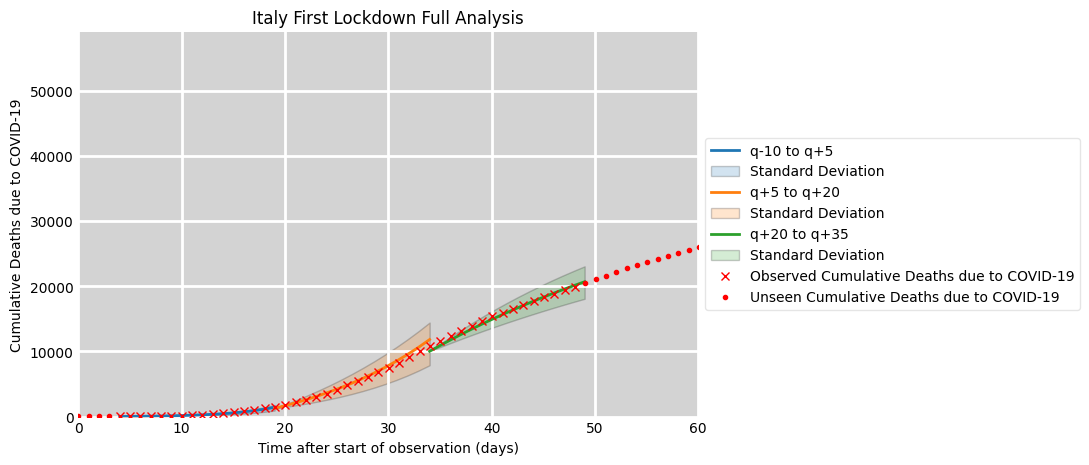

In [18]:
fullAnalaysis_SIRD("Italy",15)

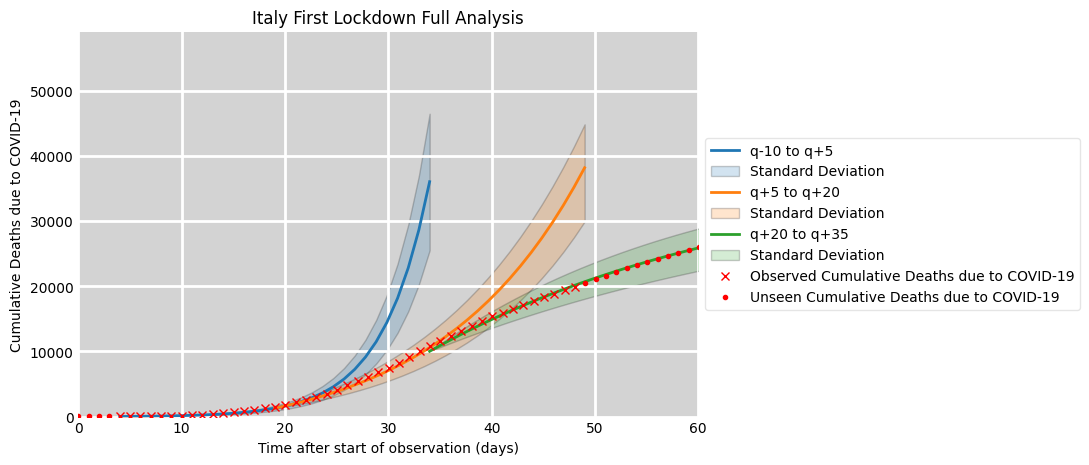

In [19]:
fullAnalaysis_SIRD("Italy",30)

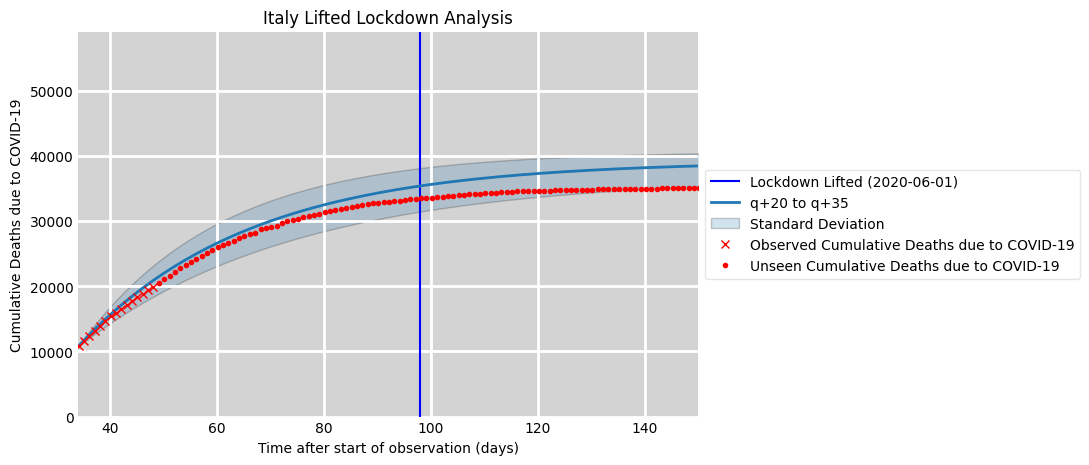

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5))    
time=150
country = "Italy"
ax.set_facecolor('lightgrey')
# Plot the data on three separate curves for S(t), I(t) and R(t)

pop = dataset[country]['pop']
startDate = dataset[country]['fLock'][0]
realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
firstDate = realData.loc[0]['date']

# before
obvData_start = timeTot(firstDate,startDate)+20
lifted_lockdown = timeTot(firstDate,"2020-06-01")
plt.axvline(x = lifted_lockdown, color = 'b', label = 'Lockdown Lifted (2020-06-01)')
death = realData["cumDeath"].tolist()
obvData_end = timeTot(firstDate,addTime(startDate,35))


df = pd.read_csv('mcmc_data/'+country+"/fLock_further_analysis.csv")
graph = plotSIRD(ax,time, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [34,150], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+20, False, "q+20 to q+35",death[obvData_start])
ax.set_title("Italy Lifted Lockdown Analysis")
final_graph =plotRealData(ax, realData, obvData_start, obvData_end, graph,14,True)